In [2]:
import string
import copy
import scipy
import Tkinter, tkFileDialog
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import sys
import datetime
import matplotlib.units
import re
from numba import jit,int32
import time
from PIL import Image
import pims
import glob
sys.path.append(os.path.abspath("C:\Users\Scherer Lab E\Documents\GitHub\Python_Data_Analysis"))
import common_functions
import half_nanoplate_functions as hnf

C:\Users\Scherer Lab E\Anaconda2\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


# Import Data
## Import Position Data of Particles
By importing the raw localized positions of particles I can use their positions to find frames where particles are far from the nanoplate edge (just like in `Ana_16052401`). From images where particles are not near the edge I can construct a median or an average to calculate the edge of.

In [3]:
'''Import the Matlab Gui Data'''
data_dir="C:\Users\Scherer Lab E\Downloads\TrackingGUI_and_associated_files_20July2014 My Version"
os.chdir(data_dir)
file_list_proc = glob.glob('Mov_012014*pre-linking_processed.mat')
data_list_proc = [common_functions.import_matlab_gui(i) for i in file_list_proc]
data_list_proc = [common_functions.matlab_gui_to_data_frame(i) for i in data_list_proc]

Loading Mov_01201403_pre-linking_processed.mat
Loading Mov_01201404_pre-linking_processed.mat
Loading Mov_01201405_pre-linking_processed.mat
Loading Mov_01201406_pre-linking_processed.mat
Loading Mov_01201407_pre-linking_processed.mat
Loading Mov_01201408_pre-linking_processed.mat


In [4]:
os.chdir("J:\Pat's Projects\Dynamical Phase Transition\Exp01201401\Half over Nanoplate")

In [5]:
folder_list = glob.glob("Mov_012*L=?\\")

In [6]:
'''Do y-flip of position data and add polar coordinates'''
transformed_data_list_proc = []
for df in data_list_proc:
    new_flip = common_functions.y_axis_flip(df, 390)
    temp_fit_params = common_functions.least_sq_fit_circle(new_flip)
    common_functions.polar_coor_data_frame(new_flip, temp_fit_params[0], temp_fit_params[1])
    transformed_data_list_proc.append(new_flip)

# Image Processing
### Construct median from images of particles far from the edge
Just like in `Ana_16052501` I create a image which is the median of the experiment including only frames where the particles are far from the nanoplate edge. Part of this image will be fit with a line to find the edge.

In [7]:
def find_frames_with_no_particles_in_theta_region(df, theta_limits, buffer_time=1):
    """Finds frames where there are no particles in a defined theta region for 
    time +/- the buffer time
    
    :params df: The DataFrame with all the particle trajectories.
    :params theta_limits: List of length 2 that defines the lower and upper
    bounds of theta that there could be no particles.
    :params buffer_time: the number of frames before and after finding a frame
    with no particles must there also be no particles to be counted."""
    
    df_theta = df.query('@theta_limits[0] < theta < @theta_limits[1]')
    unique_frames = df_theta.drop_duplicates(subset='frame')
    
    low_frames = unique_frames[unique_frames.frame.shift(-1) - unique_frames.frame > 1+2*buffer_time]
    high_frames = unique_frames[unique_frames.frame - unique_frames.frame.shift(1) > 1+2*buffer_time]
    zipped_frames = zip(low_frames.frame, high_frames.frame)
    frame_list = []
    for low, high in zipped_frames:
        frame_list += range(int(low)+1+buffer_time, int(high)-buffer_time)
    return frame_list

Calculate the median of frames w/o particles near the barrier

In [8]:
median_list = []
for num, folder in enumerate(folder_list):
    print folder
    image_seq = pims.ImageSequence(folder+'*.tif')
    frames = find_frames_with_no_particles_in_theta_region(transformed_data_list_proc[num], theta_limits=[240,300], buffer_time=1)
    median = np.median(image_seq[frames], axis=0)
    median_list.append(median)

Mov_01201403 - L=1\
Mov_01201404 - L=2\
Mov_01201405 - L=3\
Mov_01201406 - L=4\
Mov_01201407 - L=5\


### Image Processing and Fitting Line
In order to determine the location of the edge I had to do several image processing steps to the median images. Here are the steps:

1. The median of a specific L is selected 
![title](Data/Figures for Notebooks/17030401 Median Image.png)

2. The image is thresholded with an Otsu threshold (default parameters) 
![title](Data/Figures for Notebooks/17030401 Thresholded Image.png)

3. The binary image is filtered so only large object are kept and small objects are removed. 
![title](Data/Figures for Notebooks/17030401 Cleaned Thresholded Image.png)

4. The binary image is multiplied by the original median image to mask off the data. Then only a section of the image is selected for the fitting (select the last 115 pixels in x to get just the falling edge of the nanoplate) 
![title](Data/Figures for Notebooks/17030401 Cut and Masked Median.png)

5. A line is fit to all the points in the image where each point is weighted by the square root of the intensity (black pixels are not weighted at all and brightest pixels weighted the most).
![title](Data/Figures for Notebooks/17030401 Fit Line to Median.png)


In [9]:
import skimage

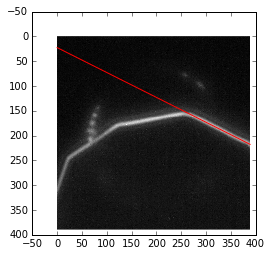

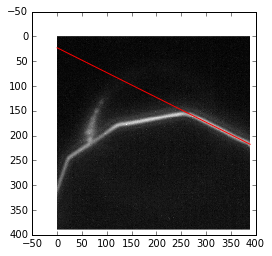

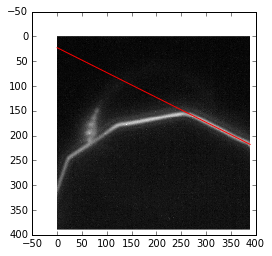

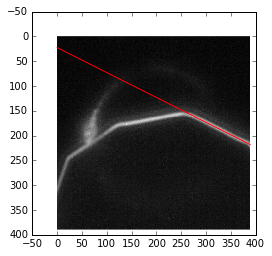

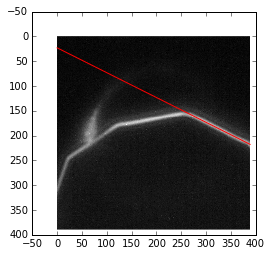

In [10]:
edge_functions = []
edge_params = []
for img in median_list:
    # Threshold the image to get just the edge
    thresh = skimage.filters.threshold_otsu(img)
    thresh_img = img > thresh
    # Cleanup binary image
    test_filter = scipy.ndimage.binary_opening(thresh_img)
    # Mask the original image with the binary
    masked = test_filter * img
    masked_barrier = masked[:,275:]
    
    # Fit a line to the image using the intensity as weighting
    y, x = np.indices(masked_barrier.shape)
    valid_z = (y.ravel() > 0) & (masked_barrier.ravel() > 0)
    x_valid = x.ravel()[valid_z]
    y_valid = y.ravel()[valid_z]
    z_valid = masked_barrier.ravel()[valid_z]
    
    z = np.polyfit(x_valid, y_valid, w=z_valid**0.5, deg=1)
    edge_params.append(z)
    p = np.poly1d(z)
    edge_func = lambda x: p(x - 275)
    edge_functions.append(edge_func)
    
    # Plot line on full image
    plt.figure()
    plt.imshow(img, cmap='gray', vmin=100, interpolation='none')

    plt.plot(np.arange(img.shape[0]), p(np.arange(img.shape[0]) - 275), 'r')
    plt.show()

## Open trajectory data and calculate proper distance to edge

Now that I have a line that defines the edge of the nanoplate I can find where that line intersects the ring trap in each experiment. The theta position of that intersection will be used in the arc length calculation of the distance to the edge.

In [11]:
store = pd.HDFStore("K:\Pat's_Projects\ParticleTrajectoryData\half_nanoplate_dynamics_processed.h5", mode='r')
keys = store.index['key']
np_pos = [store.get(v).drop_duplicates(['frame', 'track id']).copy() for v in keys[:-1]]
store.close()

Write functions to find the distance to the edge along the arc of the average radius

In [12]:
def find_circle_line_intersection(r_avg, x_cent, y_cent, slope, y_int):
    """Finds where a line interesects a circle"""
    a = 1 + slope**2
    b = -2*x_cent + 2*slope*y_int - 2*slope*y_cent
    c = -r_avg**2 + x_cent**2 + y_int**2 - 2*y_int*y_cent + y_cent**2

    x1 = (-b + (b**2 - 4*a*c)**0.5)/(2*a)
    x2 = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    
    y1 = slope*x1 + y_int
    y2 = slope*x2 + y_int
    
    return [(x1, y1), (x2, y2)]

def find_edge_in_theta(df, slope, y_int):
    """Calculates the position (in theta) where the edge of the nanoplate 
    (defined by a function of a line) intersects with the ring trap.
    
    :param df: DataFrame of particle positions in the half nanoplate experiment
    :param slope: The slope of the edge in the image data. The slope will be 
    flipped in y to match the trajectory data and will be shifted by 275 pixels
    to account for the lines' position in the full frame
    :param y_int: the y intercept of the fit to the edge of the nanoplate
    """
    near_edge = df.query('245 < theta < 310')
    r_avg = near_edge.r.mean()
    print "r_avg1 ="+str(r_avg)
    r_avg = near_edge.query('@r_avg-10 < r < @r_avg+10').r.mean()
    print slope, y_int, r_avg
    # Get relavent polar coordinate info
    x = df.loc[0, 'x pos']
    y = df.loc[0, 'y pos']
    r = df.loc[0, 'r']
    theta = df.loc[0, 'theta']
    x_cent, y_cent = common_functions.calc_cent_from_polar(x, y, r, theta)
    print x_cent, y_cent
    y_int_cor = slope*(-275) + y_int
    slope_cor = -slope
    y_int_cor = -y_int_cor + 390
    
    int_1, int_2 = find_circle_line_intersection(r_avg, x_cent, y_cent, slope_cor, y_int_cor)
    
    ang_1 = common_functions.calc_angle(int_1[0], int_1[1], x_cent, y_cent)
    ang_2 = common_functions.calc_angle(int_2[0], int_2[1], x_cent, y_cent)
    
    return ang_1, ang_2
    
find_edge_in_theta(np_pos[0], edge_params[0][0], edge_params[0][1])

r_avg1 =132.802243056
0.501358420234 160.465330538 132.841543568
202.103435464 188.631587418


(274.7850214861935, 31.960413043996056)

## Write to pickle file

Save relevant variables to a pickle file for plotting the figures for the paper.

In [16]:
import cPickle

f = open("C:\Users\Scherer Lab E\Box Sync\Half-Nanoplate\Figures and Data\Data\\log_pd_experiment.pkl", 'w')
cPickle.dump([log_pd_ls, edge_dist_ls, theta_ls, edge_loc_theta, avg_r_ls], f)
f.close()